In [166]:
#!/usr/bin/env python
"""CEVAE model on IHDP
"""

import edward2 as ed
import tensorflow as tf
import tf_slim as slim
import matplotlib.pyplot as plt
import copy
# import tensorflow_probability as tfp
# tfd = tf

from progressbar import ETA, Bar, Percentage, ProgressBar

from datasets import IHDP
from evaluation import Evaluator
import numpy as np
import time
from scipy.stats import sem

from utils import fc_net, get_y0_y1
from argparse import ArgumentParser
# from earlystopping import EarlyStopping

class Args:
    reps = 1 #10
    earl = 10 #10
    lr = 0.0005 #0.001
    opt = "adam"
    epochs = 100 #100
    print_every = 1 #10
    true_post = True
    
args = Args()

args.true_post = True

dataset = IHDP(replications=args.reps)
dimx = 25
scores = np.zeros((args.reps, 3))
scores_test = np.zeros((args.reps, 3))

M = None  # batch size during training
d = 20  # latent dimension
lamba = 1e-4  # weight decay
nh, h = 3, 200  # number and size of hidden layers

In [167]:
for i, (train, valid, test, contfeats, binfeats) in enumerate(dataset.get_train_valid_test()):
    print('\nReplication {}/{}'.format(i + 1, args.reps))
    (xtr, ttr, ytr), (y_cftr, mu0tr, mu1tr) = train
    (xva, tva, yva), (y_cfva, mu0va, mu1va) = valid
    (xte, tte, yte), (y_cfte, mu0te, mu1te) = test
    evaluator_test = Evaluator(yte, tte, y_cf=y_cfte, mu0=mu0te, mu1=mu1te)

    # reorder features with binary first and continuous after
    perm = binfeats + contfeats
    xtr, xva, xte = xtr[:, perm], xva[:, perm], xte[:, perm]

    xalltr, talltr, yalltr = np.concatenate([xtr, xva], axis=0), np.concatenate([ttr, tva], axis=0), np.concatenate([ytr, yva], axis=0)
    evaluator_train = Evaluator(yalltr, talltr, y_cf=np.concatenate([y_cftr, y_cfva], axis=0),
                                mu0=np.concatenate([mu0tr, mu0va], axis=0), mu1=np.concatenate([mu1tr, mu1va], axis=0))

    # zero mean, unit variance for y during training
    ym, ys = np.mean(ytr), np.std(ytr)
    ytr, yva = (ytr - ym) / ys, (yva - ym) / ys
    best_logpvalid = - np.inf
    best_avg_loss = - np.inf

    with tf.Graph().as_default():
        sess = tf.compat.v1.Session()
        # sess = tf.Session()

        # ed.set_seed(1)
        initializer = tf.keras.initializers.GlorotNormal(seed = 0)
        np.random.seed(1)
        tf.compat.v1.set_random_seed(1)
        """
        x_ph_bin = tf.Variable(tf.zeros([M, len(binfeats)]), name='x_bin') # binary inputs
        x_ph_cont = tf.Variable(dtype=tf.float32, shape=[M, len(contfeats)], name='x_cont') # continuous inputs
        t_ph = tf.Variable(dtype=tf.float32, shape=[M, 1])
        y_ph = tf.Variable(dtype=tf.float32, shape=[M, 1])
      
        """
        x_ph_bin = tf.compat.v1.placeholder(tf.float32, [M, len(binfeats)], name='x_bin')  # binary inputs
        x_ph_cont = tf.compat.v1.placeholder(tf.float32, [M, len(contfeats)], name='x_cont')  # continuous inputs
        t_ph = tf.compat.v1.placeholder(tf.float32, [M, 1])
        t_ph2 = tf.compat.v1.placeholder(tf.float32, [M, 1])
        y_ph = tf.compat.v1.placeholder(tf.float32, [M, 1])
        

        x_ph = tf.concat([x_ph_bin, x_ph_cont], 1)
        activation = tf.nn.elu

        # もとの分布
        # CEVAE model (decoder)
        # p(z)
        z = ed.Normal(loc=tf.zeros([tf.shape(input=x_ph)[0], d]), scale=tf.ones([tf.shape(input=x_ph)[0], d]))

        # p(x|z)
        hx = fc_net(z, (nh - 1) * [h], [], 'px_z_shared', lamba=lamba, activation=activation)
        logits = fc_net(hx, [h], [[len(binfeats), None]], 'px_z_bin'.format(i + 1), lamba=lamba, activation=activation)
        x1 = ed.Bernoulli(logits=logits, dtype=tf.float32, name='bernoulli_px_z')

        mu, sigma = fc_net(hx, [h], [[len(contfeats), None], [len(contfeats), tf.nn.softplus]], 'px_z_cont', lamba=lamba,
                           activation=activation)
        x2 = ed.Normal(loc=mu, scale=sigma, name='gaussian_px_z')

        # p(t|z)
        logitst = fc_net(z, [h], [[1, None]], 'pt_z', lamba=lamba, activation=activation)
        t = ed.Bernoulli(logits=logitst, dtype=tf.float32)

        # p(y|t,z)
        mu2_t0 = fc_net(z, nh * [h], [[1, None]], 'py_t0z', lamba=lamba, activation=activation)
        mu2_t1 = fc_net(z, nh * [h], [[1, None]], 'py_t1z', lamba=lamba, activation=activation)
        y = ed.Normal(loc=t * mu2_t1 + (1. - t) * mu2_t0, scale=tf.ones_like(mu2_t0))

        # CEVAE variational approximation (encoder)
        # q(t|x)
        logits_t = fc_net(x_ph, [d], [[1, None]], 'qt', lamba=lamba, activation=activation)
        qt = ed.Bernoulli(logits=logits_t, dtype=tf.float32)
        # q(y|x,t)
        hqy = fc_net(x_ph, (nh - 1) * [h], [], 'qy_xt_shared', lamba=lamba, activation=activation)
        mu_qy_t0 = fc_net(hqy, [h], [[1, None]], 'qy_xt0', lamba=lamba, activation=activation)
        mu_qy_t1 = fc_net(hqy, [h], [[1, None]], 'qy_xt1', lamba=lamba, activation=activation)
        qy = ed.Normal(loc=qt * mu_qy_t1 + (1. - qt) * mu_qy_t0, scale=tf.ones_like(mu_qy_t0))
        # q(z|x,t,y)
        inpt2 = tf.concat([x_ph, qy], 1)
        hqz = fc_net(inpt2, (nh - 1) * [h], [], 'qz_xty_shared', lamba=lamba, activation=activation)
        muq_t0, sigmaq_t0 = fc_net(hqz, [h], [[d, None], [d, tf.nn.softplus]], 'qz_xt0', lamba=lamba,
                                   activation=activation)
        muq_t1, sigmaq_t1 = fc_net(hqz, [h], [[d, None], [d, tf.nn.softplus]], 'qz_xt1', lamba=lamba,
                                   activation=activation)
        qz = ed.Normal(loc=qt * muq_t1 + (1. - qt) * muq_t0, scale=qt * sigmaq_t1 + (1. - qt) * sigmaq_t0)
        
        # Create data dictionary for edward
        data = {x1: x_ph_bin, x2: x_ph_cont, y: y_ph, qt: t_ph, t: t_ph, qy: y_ph}
        
        # Compute expected log-likelihood. First, sample from the variational distribution; second, compute the log-likelihood given the sample.
        
        # sample posterior predictive for p(y|z,t)
        # y_post = ed.copy(y, {z: qz, t: t_ph}, scope='y_post')
        # mu2_t0_y_post = fc_net(qz, nh * [h], [[1, None]], 'py_t0z_y_post', lamba=lamba, activation=activation)
        # mu2_t1_y_post = fc_net(qz, nh * [h], [[1, None]], 'py_t1z_y_post', lamba=lamba, activation=activation)
        # y_post_dist = ed.Normal(loc=t_ph * mu2_t1_y_post + (1. - t_ph) * mu2_t0_y_post, scale=tf.ones_like(mu2_t0_y_post))
        # y_post = y_post_dist.distribution.sample(seed = 0)
        
        # crude approximation of the above
        # y_post_mean = ed.copy(y, {z: qz.mean(), t: t_ph}, scope='y_post_mean')
        # mu2_t0_y_post_mean = fc_net(qz.distribution.mean(), nh * [h], [[1, None]], 'py_t0z_y_post_mean', lamba=lamba, activation=activation)
        # mu2_t1_y_post_mean = fc_net(qz.distribution.mean(), nh * [h], [[1, None]], 'py_t1z_y_post_mean', lamba=lamba, activation=activation)
        # y_post_mean_dist = ed.Normal(loc=t_ph * mu2_t1_y_post_mean + (1. - t_ph) * mu2_t0_y_post_mean, scale=tf.ones_like(mu2_t0_y_post_mean))
        # y_post_mean = y_post_mean_dist.distribution.sample()
        
        # inference用の分布
        # qz
        inpt2_post_eval_and_inf = tf.concat([x_ph, y_ph], 1)
        hqz_post_eval_and_inf = fc_net(inpt2_post_eval_and_inf, (nh - 1) * [h], [], 'qz_xty_shared_post_eval_and_inf', lamba=lamba, activation=activation)
        muq_t0_post_eval_and_inf, sigmaq_t0_post_eval_and_inf = fc_net(hqz_post_eval_and_inf, [h], [[d, None], [d, tf.nn.softplus]], 'qz_xt0_post_eval_and_inf', lamba=lamba,
                                   activation=activation)
        muq_t1_post_eval_and_inf, sigmaq_t1_post_eval_and_inf = fc_net(hqz_post_eval_and_inf, [h], [[d, None], [d, tf.nn.softplus]], 'qz_xt1_post_eval_and_inf', lamba=lamba,
                                   activation=activation)
        qz_post_eval_and_inf = ed.Normal(loc=t_ph * muq_t1_post_eval_and_inf + (1. - t_ph) * muq_t0_post_eval_and_inf, scale=t_ph * sigmaq_t1_post_eval_and_inf + (1. - t_ph) * sigmaq_t0_post_eval_and_inf)
        
        # 補助分布
        logits_t_inf = fc_net(x_ph, [d], [[1, None]], 'qt_inf', lamba=lamba, activation=activation)
        qt_inf_dist = ed.Bernoulli(logits=logits_t_inf, dtype=tf.float32)
        qt_inf = qt_inf_dist.distribution.sample(seed=0)
        hqy_inf = fc_net(x_ph, (nh - 1) * [h], [], 'qy_xt_shared_inf', lamba=lamba, activation=activation)
        mu_qy_t0_inf = fc_net(hqy_inf, [h], [[1, None]], 'qy_xt0_inf', lamba=lamba, activation=activation)
        mu_qy_t1_inf = fc_net(hqy_inf, [h], [[1, None]], 'qy_xt1_inf', lamba=lamba, activation=activation)
        qy_inf_dist = ed.Normal(loc=qt_inf_dist * mu_qy_t1_inf + (1. - qt_inf_dist) * mu_qy_t0_inf, scale=tf.ones_like(mu_qy_t0_inf))
        qy_inf = qy_inf_dist.distribution.sample(seed=0)
        # qy_inf = qy_inf_dist.distribution.mean()
        
        # モデルネットワーク
        # sampleの部分変えた
        """
        hx_inf = fc_net(qz_post_eval_and_inf, (nh - 1) * [h], [], 'px_z_shared_inf', lamba=lamba, activation=activation)
        logits_inf = fc_net(hx_inf, [h], [[len(binfeats), None]], 'px_z_bin_inf'.format(i + 1), lamba=lamba, activation=activation)
        x1_inf = ed.Bernoulli(logits=logits_inf, dtype=tf.float32, name='bernoulli_px_z_inf')
        mu_inf, sigma_inf = fc_net(hx_inf, [h], [[len(contfeats), None], [len(contfeats), tf.nn.softplus]], 'px_z_cont_inf', lamba=lamba,
                           activation=activation)
        x2_inf = ed.Normal(loc=mu_inf, scale=sigma_inf, name='gaussian_px_z_inf')
        logits_t_inf = fc_net(qz_post_eval_and_inf, [h], [[1, None]], 'pt_z_inf', lamba=lamba, activation=activation)
        t_inf_dist = ed.Bernoulli(logits=logits_t_inf, dtype=tf.float32)
        mu2_t0_inf = fc_net(qz_post_eval_and_inf, nh * [h], [[1, None]], 'py_t0z_inf', lamba=lamba, activation=activation)
        mu2_t1_inf = fc_net(qz_post_eval_and_inf, nh * [h], [[1, None]], 'py_t1z_inf', lamba=lamba, activation=activation)
        y_inf = ed.Normal(loc=t_inf_dist * mu2_t1_inf + (1. - t_inf_dist) * mu2_t0_inf, scale=tf.ones_like(mu2_t0_inf))
        """
        hx_inf = fc_net(qz_post_eval_and_inf.distribution.sample(seed=0), (nh - 1) * [h], [], 'px_z_shared_inf', lamba=lamba, activation=activation)
        logits_inf = fc_net(hx_inf, [h], [[len(binfeats), None]], 'px_z_bin_inf'.format(i + 1), lamba=lamba, activation=activation)
        x1_inf = ed.Bernoulli(logits=logits_inf, dtype=tf.float32, name='bernoulli_px_z_inf')
        mu_inf, sigma_inf = fc_net(hx_inf, [h], [[len(contfeats), None], [len(contfeats), tf.nn.softplus]], 'px_z_cont_inf', lamba=lamba,
                           activation=activation)
        x2_inf = ed.Normal(loc=mu_inf, scale=sigma_inf, name='gaussian_px_z_inf')
        logits_t_inf = fc_net(qz_post_eval_and_inf.distribution.sample(seed=0), [h], [[1, None]], 'pt_z_inf', lamba=lamba, activation=activation)
        t_inf_dist = ed.Bernoulli(logits=logits_t_inf, dtype=tf.float32)
        mu2_t0_inf = fc_net(qz_post_eval_and_inf.distribution.sample(seed=0), nh * [h], [[1, None]], 'py_t0z_inf', lamba=lamba, activation=activation)
        mu2_t1_inf = fc_net(qz_post_eval_and_inf.distribution.sample(seed=0), nh * [h], [[1, None]], 'py_t1z_inf', lamba=lamba, activation=activation)
        y_inf = ed.Normal(loc=t_inf_dist.distribution.sample(seed=0) * mu2_t1_inf + (1. - t_inf_dist.distribution.sample(seed=0)) * mu2_t0_inf, scale=tf.ones_like(mu2_t0_inf))
        
        y_inf2 = ed.Normal(loc=t_ph * mu2_t1_inf + (1. - t_ph) * mu2_t0_inf, scale=tf.ones_like(mu2_t0_inf))
        inference = tf.reduce_mean(input_tensor=tf.reduce_sum(input_tensor=x1_inf.distribution.log_prob(x_ph_bin),axis=1) + tf.reduce_sum(input_tensor=x2_inf.distribution.log_prob(x_ph_cont),axis=1) + tf.reduce_sum(input_tensor=y_inf.distribution.log_prob(y_ph),axis=1) + tf.reduce_sum(input_tensor=qt_inf_dist.distribution.log_prob(t_ph),axis=1) + tf.reduce_sum(input_tensor=t_inf_dist.distribution.log_prob(t_ph),axis=1) + tf.reduce_sum(input_tensor=qy_inf_dist.distribution.log_prob(y_ph),axis=1) + tf.reduce_sum(input_tensor=z.distribution.log_prob(qz_post_eval_and_inf.distribution.mean())) - tf.reduce_sum(input_tensor=qz_post_eval_and_inf.distribution.log_prob(qz_post_eval_and_inf.distribution.mean()),axis=1))
        # inference = tf.reduce_mean(input_tensor=tf.reduce_sum(input_tensor=x1_post_eval_dist.distribution.log_prob(x_ph_bin),axis=1) + tf.reduce_sum(input_tensor=x2_post_eval_dist.distribution.log_prob(x_ph_cont),axis=1) + tf.reduce_sum(input_tensor=y_post_eval_dist.distribution.log_prob(y_ph),axis=1) + tf.reduce_sum(input_tensor=qt_inf.distribution.log_prob(t_ph),axis=1) + tf.reduce_sum(input_tensor=t_post_eval_dist.distribution.log_prob(t_ph),axis=1) + tf.reduce_sum(input_tensor=qy_inf_dist.distribution.log_prob(y_ph),axis=1) + tf.reduce_sum(input_tensor=z.distribution.log_prob(qz_post_eval_and_inf.distribution.mean())) - tf.reduce_sum(input_tensor=qz_post_eval_and_inf.distribution.log_prob(qz_post_eval_and_inf.distribution.mean()),axis=1))
        
        train_op = tf.compat.v1.train.AdamOptimizer(args.lr).minimize(-inference)
        
        # logpvalid計算用の分布
        # construct a deterministic version (i.e. use the mean of the approximate posterior) of the lower bound
        # for early stopping according to a validation set
        # y_post_eval = ed.copy(y, {z: qz.mean(), qt: t_ph, qy: y_ph, t: t_ph}, scope='y_post_eval')
        mu2_t0_post_eval = fc_net(qz_post_eval_and_inf.distribution.mean(), nh * [h], [[1, None]], 'py_t0z_post_eval', lamba=lamba, activation=activation)
        mu2_t1_post_eval = fc_net(qz_post_eval_and_inf.distribution.mean(), nh * [h], [[1, None]], 'py_t1z_post_eval', lamba=lamba, activation=activation)
        y_post_eval_dist = ed.Normal(loc=t_ph * mu2_t1_post_eval + (1. - t_ph) * mu2_t0_post_eval, scale=tf.ones_like(mu2_t0_post_eval))
        # y_post_eval = y_post_eval_dist.distribution.sample()
        
        # x1_post_eval = x1, {z: qz.mean(), qt: t_ph, qy: y_ph}
        hx_post_eval = fc_net(qz_post_eval_and_inf.distribution.mean(), (nh - 1) * [h], [], 'px_z_shared_post_eval', lamba=lamba, activation=activation)
        logits_post_eval = fc_net(hx_post_eval, [h], [[len(binfeats), None]], 'px_z_bin_x_post_eval'.format(i + 1), lamba=lamba, activation=activation)
        x1_post_eval_dist = ed.Bernoulli(logits=logits_post_eval, dtype=tf.float32, name='bernoulli_px_z_post_eval')
        # x1_post_eval = x1_post_eval_dist.distribution.sample()
        
        # x2_post_eval = x2, {z: qz.mean(), qt: t_ph, qy: y_ph}
        mu_x2_post_eval, sigma_x2_post_eval = fc_net(hx_post_eval, [h], [[len(contfeats), None], [len(contfeats), tf.nn.softplus]], 'px_z_cont_post_eval', lamba=lamba, activation=activation)
        x2_post_eval_dist = ed.Normal(loc=mu_x2_post_eval, scale=sigma_x2_post_eval, name='gaussian_px_z_post_eval')
        # x2_post_eval = x2_post_eval_dist.distribution.sample()
        
        # t_post_eval = ed.copy(t, {z: qz.mean(), qt: t_ph, qy: y_ph}, scope='t_post_eval')
        logitst_post_eval = fc_net(qz_post_eval_and_inf.distribution.mean(), [h], [[1, None]], 'pt_z_post_eval', lamba=lamba, activation=activation)
        t_post_eval_dist = ed.Bernoulli(logits=logitst_post_eval, dtype=tf.float32)
        # t_post_eval = y_post_eval_dist.distribution.sample()
    
        """
        logp_valid = tf.reduce_mean(input_tensor=tf.reduce_sum(input_tensor=y_inf.distribution.log_prob(y_ph) + t_inf_dist.distribution.log_prob(t_ph), axis=1) +
                                    tf.reduce_sum(input_tensor=x1_inf.distribution.log_prob(x_ph_bin), axis=1) +
                                    tf.reduce_sum(input_tensor=x2_inf.distribution.log_prob(x_ph_cont), axis=1) +
                                    tf.reduce_sum(input_tensor=z.distribution.log_prob(qz_post_eval_and_inf.distribution.mean()) - qz_post_eval_and_inf.distribution.log_prob(qz_post_eval_and_inf.distribution.mean()), axis=1))
        
        """
        logp_valid = tf.reduce_mean(input_tensor=tf.reduce_sum(input_tensor=y_post_eval_dist.distribution.log_prob(y_ph) + t_post_eval_dist.distribution.log_prob(t_ph), axis=1) +
                                    tf.reduce_sum(input_tensor=x1_post_eval_dist.distribution.log_prob(x_ph_bin), axis=1) +
                                    tf.reduce_sum(input_tensor=x2_post_eval_dist.distribution.log_prob(x_ph_cont), axis=1) +
                                    tf.reduce_sum(input_tensor=z.distribution.log_prob(qz_post_eval_and_inf.distribution.mean()) - qz_post_eval_and_inf.distribution.log_prob(qz_post_eval_and_inf.distribution.mean()), axis=1))
        """
        # 推論ネットワーク評価指標計算用
        inpt2_inf2 = tf.concat([x_ph, qy_inf], 1)
        hqz_inf2 = fc_net(inpt2_inf2, (nh - 1) * [h], [], 'qz_xty_shared_inf2', lamba=lamba, activation=activation)
        muq_t0_inf2, sigmaq_t0_inf2 = fc_net(hqz_inf2, [h], [[d, None], [d, tf.nn.softplus]], 'qz_xt0_inf2', lamba=lamba,
                                   activation=activation)
        muq_t1_inf2, sigmaq_t1_inf2 = fc_net(hqz_inf2, [h], [[d, None], [d, tf.nn.softplus]], 'qz_xt1_inf2', lamba=lamba,
                                   activation=activation)
        qz_inf2 = ed.Normal(loc=t_ph * muq_t1_inf2 + (1. - t_ph) * muq_t0_inf2, scale=t_ph * sigmaq_t1_inf2 + (1. - t_ph) * sigmaq_t0_inf2)
        hx_inf2 = fc_net(qz_inf2.distribution.sample(seed=0), (nh - 1) * [h], [], 'px_z_shared_in2f', lamba=lamba, activation=activation)
        logits_inf2 = fc_net(hx_inf2, [h], [[len(binfeats), None]], 'px_z_bin_inf2'.format(i + 1), lamba=lamba, activation=activation)
        x1_inf2 = ed.Bernoulli(logits=logits_inf2, dtype=tf.float32, name='bernoulli_px_z_inf2')
        mu_inf2, sigma_inf2 = fc_net(hx_inf2, [h], [[len(contfeats), None], [len(contfeats), tf.nn.softplus]], 'px_z_cont_inf2', lamba=lamba,
                           activation=activation)
        x2_inf2 = ed.Normal(loc=mu_inf2, scale=sigma_inf2, name='gaussian_px_z_inf2')
        logits_t_inf2 = fc_net(qz_inf2.distribution.sample(seed=0), [h], [[1, None]], 'pt_z_inf2', lamba=lamba, activation=activation)
        t_inf2 = ed.Bernoulli(logits=logits_t_inf2, dtype=tf.float32)
        mu2_t0_inf2 = fc_net(qz_inf2.distribution.sample(seed=0), nh * [h], [[1, None]], 'py_t0z_inf2', lamba=lamba, activation=activation)
        mu2_t1_inf2 = fc_net(qz_inf2.distribution.sample(seed=0), nh * [h], [[1, None]], 'py_t1z_inf2', lamba=lamba, activation=activation)
        y_inf2 = ed.Normal(loc=t_inf2 * mu2_t1_inf2 + (1. - t_inf2) * mu2_t0_inf2, scale=tf.ones_like(mu2_t0_inf2))
        """
       
        # sess.run(tf.initialize_all_variables())
        sess.run(tf.compat.v1.global_variables_initializer())
        # tf.compat.v1.global_variables_initializer().run(session=sess)
        saver = tf.compat.v1.train.Saver()
        # saver = tf.keras.Model.save_weights(save_format='h5')
        # saver = tf.compat.v1.train.Saver(slim.get_variables())
        # kernel_initializer=initializers.glorot_uniform(seed=0)))

        n_epoch, n_iter_per_epoch, idx = args.epochs, 10 * int(xtr.shape[0] / 100), np.arange(xtr.shape[0])

        # dictionaries needed for evaluation
        tr0, tr1 = np.zeros((xalltr.shape[0], 1)), np.ones((xalltr.shape[0], 1))
        tr0t, tr1t = np.zeros((xte.shape[0], 1)), np.ones((xte.shape[0], 1))
        
        f1 = {x_ph_bin: xalltr[:, 0:len(binfeats)], x_ph_cont: xalltr[:, len(binfeats):], t_ph: tr1}
        f0 = {x_ph_bin: xalltr[:, 0:len(binfeats)], x_ph_cont: xalltr[:, len(binfeats):], t_ph: tr0}
        f1t = {x_ph_bin: xte[:, 0:len(binfeats)], x_ph_cont: xte[:, len(binfeats):], t_ph: tr1t}
        f0t = {x_ph_bin: xte[:, 0:len(binfeats)], x_ph_cont: xte[:, len(binfeats):], t_ph: tr0t}
        # loss = np.zeros(n_epoch*n_iter_per_epoch)
        # logpvalid_list = np.zeros(n_iter_per_epoch*n_epoch)
        avg_loss_list = np.zeros(n_iter_per_epoch*n_epoch)
        logpvalid_list = np.zeros(n_iter_per_epoch*n_epoch)
        ite_train_list = np.zeros(n_epoch)
        ate_train_list = np.zeros(n_epoch)
        pehe_train_list = np.zeros(n_epoch)
        rmse_f_list = np.zeros(n_epoch)
        rmse_cf_list = np.zeros(n_epoch)
        ite_test_list = np.zeros(n_epoch)
        ate_test_list = np.zeros(n_epoch)
        pehe_test_list = np.zeros(n_epoch)
        
        for epoch in range(n_epoch):
            avg_loss = 0.0
            t0 = time.time()
            widgets = ["epoch #%d|" % epoch, Percentage(), Bar(), ETA()]
            pbar = ProgressBar(n_iter_per_epoch, widgets=widgets)
            pbar.start()
            np.random.shuffle(idx)
            
            for j in range(n_iter_per_epoch):
              pbar.update(j)
              batch = np.random.choice(idx, 100)
              x_train, y_train, t_train = xtr[batch], ytr[batch], ttr[batch]
              _, info_dict = sess.run([train_op, inference], feed_dict = {x_ph_bin: x_train[:, 0:len(binfeats)],
                                                        x_ph_cont: x_train[:, len(binfeats):],
                                                        t_ph: t_train, y_ph: y_train})
              
              logpvalid = sess.run(logp_valid, feed_dict={x_ph_bin: xva[:, 0:len(binfeats)], x_ph_cont: xva[:, len(binfeats):], t_ph: tva, y_ph: yva})
              avg_loss_list[epoch*n_iter_per_epoch+j] = info_dict
              avg_loss += info_dict
              logpvalid_list[epoch*n_iter_per_epoch+j] = logpvalid
            
            avg_loss = avg_loss / n_iter_per_epoch
            avg_loss = avg_loss / 100
            saver.save(sess, "models/m6-ihdp")
            
            if epoch % args.earl == 0 or epoch == (n_epoch - 1):
                # logpvalid = sess.run(logp_valid, feed_dict={x_ph_bin: xva[:, 0:len(binfeats)], x_ph_cont: xva[:, len(binfeats):], t_ph: tva, y_ph: yva})
                
                if logpvalid >= best_logpvalid:
                  print('Improved validation bound, old: {:0.3f}, new: {:0.3f}'.format(best_logpvalid, logpvalid))
                  best_logpvalid = logpvalid
                  # saver.save(sess, "models/m6-ihdp")
            
            if epoch % args.print_every == 0:
                
                qy_forinf_train = sess.run(qy_inf, feed_dict = {x_ph_bin: xalltr[:, 0:len(binfeats)], x_ph_cont: xalltr[:, len(binfeats):]})
                qy_forinf_test = sess.run(qy_inf, feed_dict = {x_ph_bin: xte[:, 0:len(binfeats)], x_ph_cont: xte[:, len(binfeats):]})
                f0[y_ph] = np.asarray(qy_forinf_train)
                f1[y_ph] = np.asarray(qy_forinf_train)
                f0t[y_ph] = np.asarray(qy_forinf_test)
                f1t[y_ph] = np.asarray(qy_forinf_test)
                
                y0, y1 = get_y0_y1(sess, y_inf2, f0, f1, shape=yalltr.shape, L=1)
                y0, y1 = y0 * ys + ym, y1 * ys + ym
                score_train = evaluator_train.calc_stats(y1, y0)
                rmses_train = evaluator_train.y_errors(y0, y1)
                
                ite_train_list[epoch] = score_train[0]
                ate_train_list[epoch] = score_train[1]
                pehe_train_list[epoch] = score_train[2]
                rmse_f_list[epoch] = rmses_train[0]
                rmse_cf_list[epoch] = rmses_train[1]
                
                y0, y1 = get_y0_y1(sess, y_inf2, f0t, f1t, shape=yte.shape, L=1)
                y0, y1 = y0 * ys + ym, y1 * ys + ym
                score_test = evaluator_test.calc_stats(y1, y0)
                
                ite_test_list[epoch] = score_test[0]
                ate_test_list[epoch] = score_test[1]
                pehe_test_list[epoch] = score_test[2]

                
                if epoch % 10 == 0:
                      print("Epoch: {}/{}, log p(x) >= {:0.3f}, ite_tr: {:0.3f}, ate_tr: {:0.3f}, pehe_tr: {:0.3f}, " \
                      "rmse_f_tr: {:0.3f}, rmse_cf_tr: {:0.3f}, ite_te: {:0.3f}, ate_te: {:0.3f}, pehe_te: {:0.3f}, " \
                      "dt: {:0.3f}".format(epoch + 1, n_epoch, avg_loss, score_train[0], score_train[1], score_train[2],
                                           rmses_train[0], rmses_train[1], score_test[0], score_test[1], score_test[2],
                                           time.time() - t0))

        saver.restore(sess, "models/m6-ihdp")
       
        qy_forinf_train = sess.run(qy_inf, feed_dict = {x_ph_bin: xalltr[:, 0:len(binfeats)], x_ph_cont: xalltr[:, len(binfeats):]})
        qy_forinf_test = sess.run(qy_inf, feed_dict = {x_ph_bin: xte[:, 0:len(binfeats)], x_ph_cont: xte[:, len(binfeats):]})
        f0[y_ph] = np.asarray(qy_forinf_train)
        f1[y_ph] = np.asarray(qy_forinf_train)
        f0t[y_ph] = np.asarray(qy_forinf_test)
        f1t[y_ph] = np.asarray(qy_forinf_test)
        
        y0, y1 = get_y0_y1(sess, y_inf2, f0, f1, shape=yalltr.shape, L=100)
        y0, y1 = y0 * ys + ym, y1 * ys + ym
        score = evaluator_train.calc_stats(y1, y0)
        scores[i, :] = score

        y0t, y1t = get_y0_y1(sess, y_inf2, f0t, f1t, shape=yte.shape, L=100)
        y0t, y1t = y0t * ys + ym, y1t * ys + ym
        score_test = evaluator_test.calc_stats(y1t, y0t)
        scores_test[i, :] = score_test

        print('Replication: {}/{}, tr_ite: {:0.3f}, tr_ate: {:0.3f}, tr_pehe: {:0.3f}' \
              ', te_ite: {:0.3f}, te_ate: {:0.3f}, te_pehe: {:0.3f}'.format(i + 1, args.reps,
                                                                            score[0], score[1], score[2],
                                                                            score_test[0], score_test[1], score_test[2]))
        sess.close()

print('CEVAE model total scores')
means, stds = np.mean(scores, axis=0), sem(scores, axis=0)
print('train ITE: {:.3f}+-{:.3f}, train ATE: {:.3f}+-{:.3f}, train PEHE: {:.3f}+-{:.3f}' \
      ''.format(means[0], stds[0], means[1], stds[1], means[2], stds[2]))

means, stds = np.mean(scores_test, axis=0), sem(scores_test, axis=0)
print('test ITE: {:.3f}+-{:.3f}, test ATE: {:.3f}+-{:.3f}, test PEHE: {:.3f}+-{:.3f}' \
      ''.format(means[0], stds[0], means[1], stds[1], means[2], stds[2]))



Replication 1/1


Improved validation bound, old: -inf, new: -25.206


Epoch: 1/100, log p(x) >= -18.640, ite_tr: 3.174, ate_tr: 4.055, pehe_tr: 4.212, rmse_f_tr: 2.277, rmse_cf_tr: 3.237, ite_te: 3.083, ate_te: 4.067, pehe_te: 4.181, dt: 4.397


Improved validation bound, old: -25.206, new: 65.554


Epoch: 11/100, log p(x) >= -17.564, ite_tr: 3.740, ate_tr: 4.348, pehe_tr: 5.012, rmse_f_tr: 2.647, rmse_cf_tr: 3.797, ite_te: 3.750, ate_te: 4.245, pehe_te: 4.926, dt: 3.408


Improved validation bound, old: 65.554, new: 86.612


Epoch: 21/100, log p(x) >= -17.337, ite_tr: 2.170, ate_tr: 2.680, pehe_tr: 3.169, rmse_f_tr: 2.160, rmse_cf_tr: 2.266, ite_te: 2.041, ate_te: 2.771, pehe_te: 3.178, dt: 3.428


Improved validation bound, old: 86.612, new: 97.435


Epoch: 31/100, log p(x) >= -17.230, ite_tr: 1.954, ate_tr: 1.466, pehe_tr: 2.229, rmse_f_tr: 1.870, rmse_cf_tr: 2.070, ite_te: 1.911, ate_te: 1.600, pehe_te: 2.086, dt: 3.456


Improved validation bound, old: 97.435, new: 105.850


Epoch: 41/100, log p(x) >= -17.168, ite_tr: 1.387, ate_tr: 0.470, pehe_tr: 1.234, rmse_f_tr: 1.622, rmse_cf_tr: 1.445, ite_te: 1.255, ate_te: 0.463, pehe_te: 1.026, dt: 3.676


Epoch: 51/100, log p(x) >= -17.303, ite_tr: 1.407, ate_tr: 0.803, pehe_tr: 1.362, rmse_f_tr: 1.608, rmse_cf_tr: 1.494, ite_te: 1.446, ate_te: 0.974, pehe_te: 1.497, dt: 3.827


Epoch: 61/100, log p(x) >= -17.246, ite_tr: 1.431, ate_tr: 0.600, pehe_tr: 1.326, rmse_f_tr: 1.622, rmse_cf_tr: 1.500, ite_te: 1.253, ate_te: 0.635, pehe_te: 1.300, dt: 4.174


Epoch: 71/100, log p(x) >= -17.195, ite_tr: 1.609, ate_tr: 1.359, pehe_tr: 1.852, rmse_f_tr: 1.734, rmse_cf_tr: 1.674, ite_te: 1.814, ate_te: 1.496, pehe_te: 1.921, dt: 3.820


Epoch: 81/100, log p(x) >= -17.240, ite_tr: 1.397, ate_tr: 0.675, pehe_tr: 1.401, rmse_f_tr: 1.682, rmse_cf_tr: 1.461, ite_te: 1.211, ate_te: 0.676, pehe_te: 1.266, dt: 3.904


Improved validation bound, old: 105.850, new: 108.333


Epoch: 91/100, log p(x) >= -17.101, ite_tr: 1.431, ate_tr: 1.430, pehe_tr: 1.789, rmse_f_tr: 1.734, rmse_cf_tr: 1.512, ite_te: 1.406, ate_te: 1.491, pehe_te: 1.767, dt: 4.039


Improved validation bound, old: 108.333, new: 109.893
INFO:tensorflow:Restoring parameters from models/m6-ihdp
 Sample 100/100
 Sample 100/100
Replication: 1/1, tr_ite: 1.324, tr_ate: 1.112, tr_pehe: 1.407, te_ite: 1.298, te_ate: 1.256, te_pehe: 1.473
CEVAE model total scores
train ITE: 1.324+-nan, train ATE: 1.112+-nan, train PEHE: 1.407+-nan
test ITE: 1.298+-nan, test ATE: 1.256+-nan, test PEHE: 1.473+-nan


c:\Users\ayuno\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


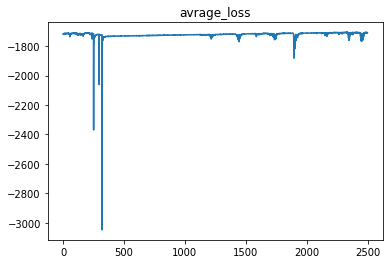

In [168]:
plt.title('avrage_loss')
plt.plot(avg_loss_list[1500:])
plt.show()

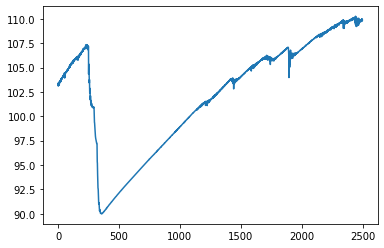

In [169]:
plt.plot(logpvalid_list[1500:])
plt.show()

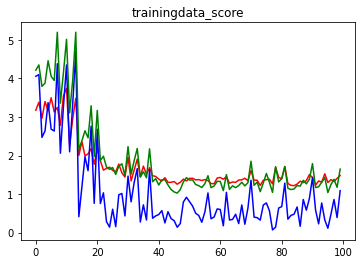

In [170]:
plt.title('trainingdata_score')
#plt.plot(ite_train_list, color = 'red', lavel = 'rmse_ITE')
#plt.plot(ate_train_list, color = 'blue', label = 'abs_ATE')
#plt.plot(pehe_train_list, color = 'green', label = 'ePEHE')
plt.plot(ite_train_list, color = 'red')
plt.plot(ate_train_list, color = 'blue')
plt.plot(pehe_train_list, color = 'green')
plt.show()

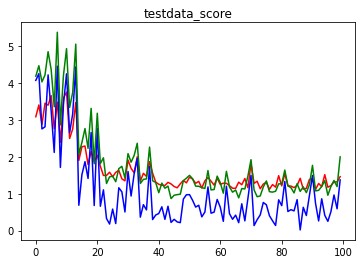

In [171]:
plt.title('testdata_score')
#plt.plot(ite_test_list, color = 'red', lavel = 'rmse_ITE')
#plt.plot(ate_test_list, color = 'blue', lavel = 'abs__ATE')
#plt.plot(pehe_test_list, color = 'green', label = 'ePEHE')
plt.plot(ite_test_list, color = 'red')
plt.plot(ate_test_list, color = 'blue')
plt.plot(pehe_test_list, color = 'green')
plt.show()

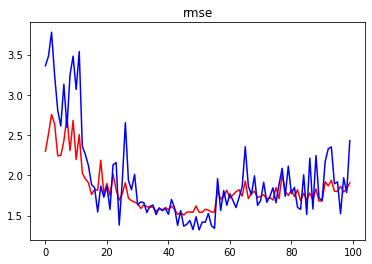

In [139]:
plt.title('rmse')
plt.plot(rmse_f_list, color = 'red')
plt.plot(rmse_cf_list, color = 'blue')
plt.show()

class EarlyStopping(object):
    def __init__(self, patience=0, verbose=0):
        self._step= 0
        self._loss=float('inf')
        self._patience=patience
        self.verbose=verbose

    def validate(self,loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self._patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self.step = 0
            self.loss = loss
       
        return False


inpt2_inf = tf.concat([x_ph, qy], 1)
        hqz_inf = fc_net(inpt2_inf, (nh - 1) * [h], [], 'qz_xty_shared_inf', lamba=lamba, activation=activation)
        muq_t0_inf, sigmaq_t0_inf = fc_net(hqz_inf, [h], [[d, None], [d, tf.nn.softplus]], 'qz_xt0_inf', lamba=lamba,
                                   activation=activation)
        muq_t1_inf, sigmaq_t1_inf = fc_net(hqz_inf, [h], [[d, None], [d, tf.nn.softplus]], 'qz_xt1_inf', lamba=lamba,
                                   activation=activation)
        qz_inf = ed.Normal(loc=qt * muq_t1_inf + (1. - qt) * muq_t0_inf, scale=qt * sigmaq_t1_inf + (1. - qt) * sigmaq_t0_inf)
        
        hx_inf = fc_net(qz, (nh - 1) * [h], [], 'px_z_shared_inf', lamba=lamba, activation=activation)
        logits_inf = fc_net(hx_inf, [h], [[len(binfeats), None]], 'px_z_bin_inf'.format(i + 1), lamba=lamba, activation=activation)
        x1_inf = ed.Bernoulli(logits=logits_inf, dtype=tf.float32, name='bernoulli_px_z_inf')
        mu_inf, sigma_inf = fc_net(hx_inf, [h], [[len(contfeats), None], [len(contfeats), tf.nn.softplus]], 'px_z_cont_inf', lamba=lamba,
                           activation=activation)
        x2_inf = ed.Normal(loc=mu_inf, scale=sigma_inf, name='gaussian_px_z_inf')
        logits_t_inf = fc_net(qz, [h], [[1, None]], 'pt_z_inf', lamba=lamba, activation=activation)
        t_inf = ed.Bernoulli(logits=logits_t_inf, dtype=tf.float32)
        mu2_t0_inf = fc_net(qz, nh * [h], [[1, None]], 'py_t0z_inf', lamba=lamba, activation=activation)
        mu2_t1_inf = fc_net(qz, nh * [h], [[1, None]], 'py_t1z_inf', lamba=lamba, activation=activation)
        y_inf = ed.Normal(loc=t_inf * mu2_t1_inf + (1. - t_inf) * mu2_t0_inf, scale=tf.ones_like(mu2_t0_inf))